In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import os

plt.rcParams['figure.figsize'] = [12, 10]
sns.set(font_scale=1.25)
np.random.seed(42)

from tqdm.notebook import tqdm

data_path = "../dataset/data/"
cell_types = os.listdir(data_path)

In [2]:
mapping = {
        "Ultra_Chrome":"UC",
        "Ultra_Chrome-separated":"X-UC",
        "Deep_Chrome":"DC",
        "Deep_Chrome-separated":"X-DC",
        "Attentive_Chrome-separated":"X-AC",     
        "Random_Forest_Classifier":"RFC",
        "ChromeR":"CR",
        "ChromeR-separated":"X-CR",
        "Base_NN":"BNN",
        "Base_NN-separated":"X-BNN",
    }
def remap(model):
    if model not in mapping:
        return model
    else:
        return mapping[model]

def remap_all(models):    
    remapped = []
    for model in models:
        remapped.append(mapping[model])
    return remapped

In [3]:
'''
    Re-order the results based on the best model
'''
def get_sorted_results():
    
    results = {}
    models = os.listdir("../results/")
    
    best_model = None
    best_AUC = 0

    for model in models:  
        if ".csv" in model:
            model_name = model.replace(".csv","")
            df = pd.read_csv(f"../results/{model}")    
            df_AUC = np.mean(df['AUC'])             
            if df_AUC > best_AUC:
                best_model = model_name
                best_AUC = df_AUC
            results[model_name] = df

    print(f"> Best model found is \'{remap(best_model)}\' with mean AUC: {best_AUC}")

    results[best_model] = results[best_model].sort_values(by=['AUC'],ascending=False)
    sorted_cell_types = results[best_model]['Cell-Type']

    for model in results:
        if model != best_model:
            results[model] = results[model].reindex(sorted_cell_types.index)
        results[model] = results[model].reset_index()

    return results

In [4]:
'''
   Plot the results after reordering for better visualization
'''
def plot_results(results):
#     linestyles = ["--","-",":"]
#     style_index=0
    for model in results:
        plt.plot(
            results[model]['AUC'], 
            label=model.replace("_"," ").replace("-separated"," individual"),
            marker='o',
#             linestyle=linestyles[style_index%len(linestyles)]
        )
#         style_index+=1
        
    plt.xlabel("56 Cell-types")
    plt.ylabel("AUC")
    plt.ylim([0.71, 0.93])
    plt.legend(loc="upper right")
    plt.show()

In [5]:
'''
    Plots the differences of the metrics between models results
'''
def plot_metrics(results):
    
    mins = []
    maxs = []
    means = []
    for model in results:
        AUC = results[model]['AUC']
        mins.append(min(AUC))
        maxs.append(max(AUC))
        means.append(np.mean(AUC))
        
    data=[
        ["Min"]+mins,
        ["Max"]+maxs, 
        ["Mean"]+means
    ]
    columns = list(results.keys())
    df = pd.DataFrame(data,columns=["Metrics"]+columns)
    df.plot(x="Metrics", y=columns, kind="bar")
    plt.xlabel("Metrics")
    plt.ylabel("AUC")
    plt.ylim([0.65, 1])
    plt.legend(loc="upper right")    
    plt.show()

In [6]:
def plot_improvements_matrix(results):
    models = list(results.keys())
    improvements_matrix = []
    improvements = []
    
    for model1 in models:
        row = []
        for model2 in models:
            m1_auc = results[model1]['AUC']
            m2_auc = results[model2]['AUC']
            comparison = m1_auc>m2_auc
            comparison = [x for x in comparison if x == True]
            row.append(len(comparison))
        improvements_matrix.append(row)        
        improvements.append((model1,sum(row)))
    
    improvements = sorted(improvements, key=lambda t: t[1], reverse=True)
    
    improvements_matrix = sorted(improvements_matrix, key=lambda row: sum(row),reverse=True)
    sorted_models = []
    for i in range(len(models)):
        row_sum = sum(improvements_matrix[i])
        for j in range(len(models)):
            if row_sum == improvements[j][1]:
                sorted_models.append(improvements[j][0])
    models = sorted_models
    
    # reset the matrix and recalculate now that "models" are ordered
    improvements_matrix = []
    improvements = []
    for model1 in models:
        row = []
        for model2 in models:
            m1_auc = results[model1]['AUC']
            m2_auc = results[model2]['AUC']
            comparison = m1_auc>m2_auc
            comparison = [x for x in comparison if x == True]
            row.append(len(comparison))
        improvements_matrix.append(row)        
        improvements.append((model1,sum(row)))
    
    improvements = sorted(improvements, key=lambda t: t[1], reverse=True)
    
    remapped = []
    for model in models:
        remapped.append(remap(model))
    models = remapped
    
    df = pd.DataFrame(improvements_matrix, index=models, columns=models)
    # plt.title("Improvements Matrix", fontsize =20)
    sns.set(font_scale=1.5)
    sns.heatmap(df, annot=True, center=20, cmap="RdPu", vmin=0, vmax=56, cbar=None)
    sns.set(font_scale=1.25)
    return improvements

In [7]:
all_results = get_sorted_results()
print(f"Found {len(all_results)} models:")
for model in all_results:
    print("-",remap(model))

> Best model found is 'X-AC' with mean AUC: 0.8115649526769252
Found 10 models:
- X-AC
- X-BNN
- BNN
- X-CR
- CR
- X-DC
- DC
- RFC
- X-UC
- UC


In [8]:
# globals
# compare_list = ["Attentive_Chrome-separated", "Deep_Chrome", "Ultra_Chrome"]
# invdividuals
# compare_list = ["Attentive_Chrome-separated", "Deep_Chrome-separated", "Ultra_Chrome-separated"]
# improvements comparison
compare_list = ["Attentive_Chrome-separated", "Deep_Chrome-separated","Ultra_Chrome-separated","Ultra_Chrome"]
# compare_list = []

results = {}

if len(compare_list)==0:
    results = all_results
else:
    for model in all_results:
        if model in compare_list:        
            results[model] = all_results[model]

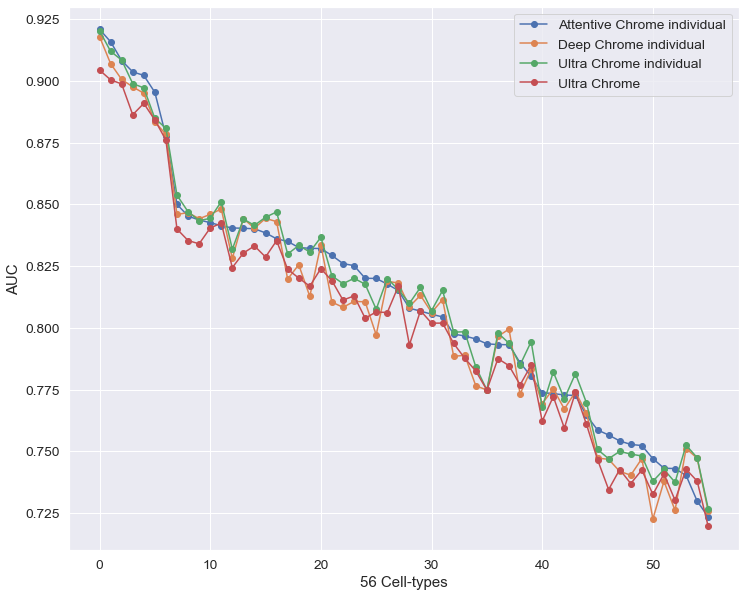

In [9]:
plot_results(results)

[('Ultra_Chrome-separated', 133), ('Attentive_Chrome-separated', 107), ('Deep_Chrome-separated', 73), ('Ultra_Chrome', 23)]


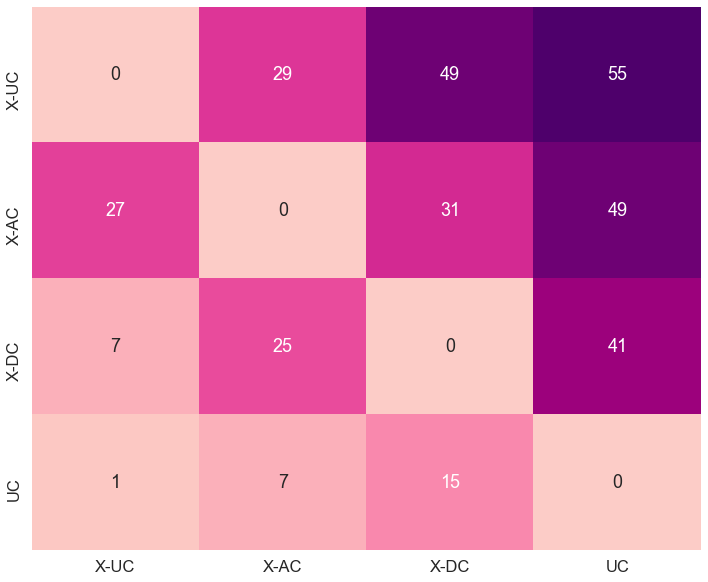

In [10]:
improvements = plot_improvements_matrix(results)
print(improvements)

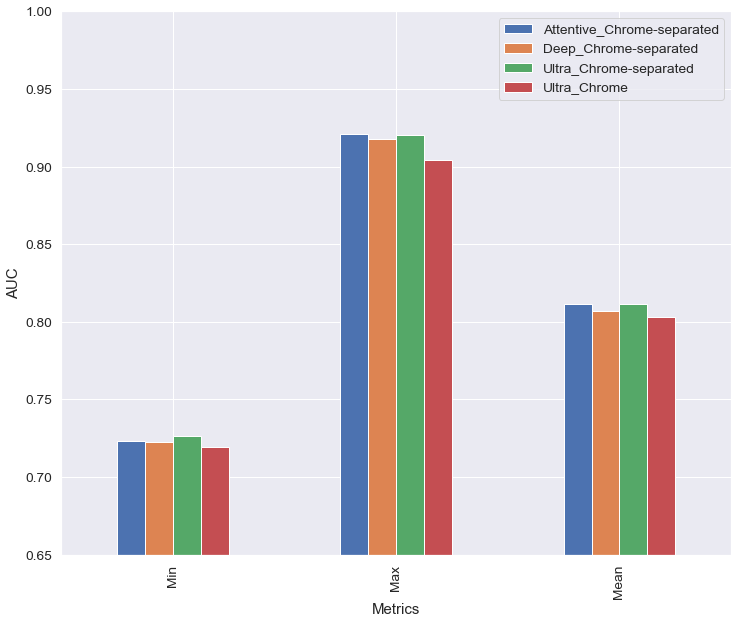

In [11]:
plot_metrics(results)

## Best/Worst predictions

In [24]:
# load test set
def load():
    print("load()")
    full_train_data = np.array([])
    full_valid_data = np.array([])
    full_test_data = np.array([])
    full_train_labels = np.array([])
    full_valid_labels = np.array([])
    full_test_labels = np.array([])

    dirs = os.listdir(data_path)
    for folder in tqdm(dirs):
        (train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load_clean_data(folder)
        # print(f"{folder} loaded")
        
        # train
        full_train_data = np.append(full_train_data, train_data)
        full_train_labels = np.append(full_train_labels, train_labels)
        # valid
        full_valid_data = np.append(full_valid_data, valid_data)
        full_valid_labels = np.append(full_valid_labels, valid_labels)
        # test
        full_test_data = np.append(full_test_data, test_data)
        full_test_labels = np.append(full_test_labels, test_labels)

    # ? reshaping
    full_train_data = full_train_data.reshape(len(full_train_labels), 5, 100, 1)
    full_valid_data = full_valid_data.reshape(len(full_valid_labels), 5, 100, 1)
    full_test_data = full_test_data.reshape(len(full_test_labels), 5, 100, 1)

    return (
        (full_train_data, full_train_labels),
        (full_valid_data, full_valid_labels),
        (full_test_data, full_test_labels)
    )

In [25]:
def load_clean_data(folder_name):
    # data
    train_data = np.load(f"{data_path}{folder_name}/train_data.npy")
    valid_data = np.load(f"{data_path}{folder_name}/valid_data.npy")
    test_data = np.load(f"{data_path}{folder_name}/test_data.npy")
    # labels
    train_labels = np.load(f"{data_path}{folder_name}/train_labels.npy")
    valid_labels = np.load(f"{data_path}{folder_name}/valid_labels.npy")
    test_labels = np.load(f"{data_path}{folder_name}/test_labels.npy")
    # return complete tuples
    return ((train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels))

In [26]:
(train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load()

load()


In [27]:
# chose the model to inspect
model_name = "Ultra_Chrome"
model = tf.keras.models.load_model(f"../models/{model_name}")        

In [28]:
# predict and sort by difference with test labels

best,worst = None,None
best_position,worst_position = None,None

test_labels = test_labels.reshape(len(test_labels),1)
predictions = model.predict(test_data)

diffs = abs(predictions-test_labels)

differences = pd.DataFrame(pd.DataFrame(list(diffs),
               columns =['Difference']))

differences.sort_values(by=['Difference'], inplace=True)

show = 5

In [29]:
def plot_gene(gene,label):
    gene = gene.reshape(5,100)
    df = pd.DataFrame(gene, index=['HM1','HM2','HM3','HM4','HM5'])
    plt.figure(figsize=(20, 5))
    sns.heatmap(df, cmap=("RdPu" if label==1 else "BuPu"))
    plt.xlabel("Bins")
    plt.ylabel("Histone modifications")
    plt.title("Gene expressed" if label==1 else "Gene not expressed")
    plt.show()

Worst 5 guesses


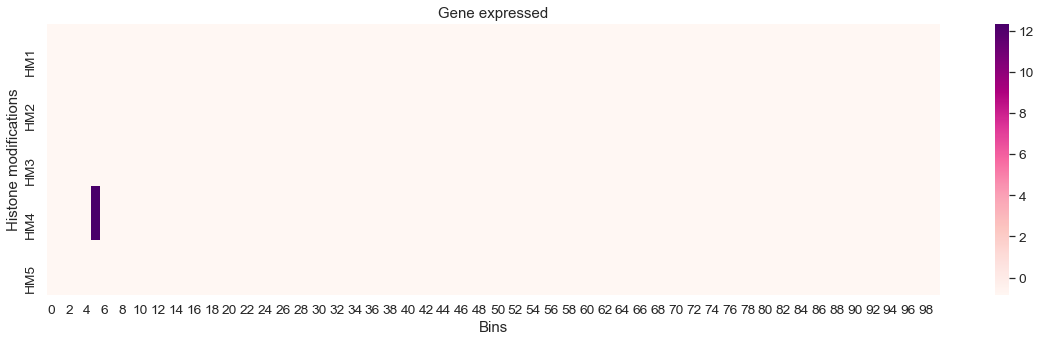

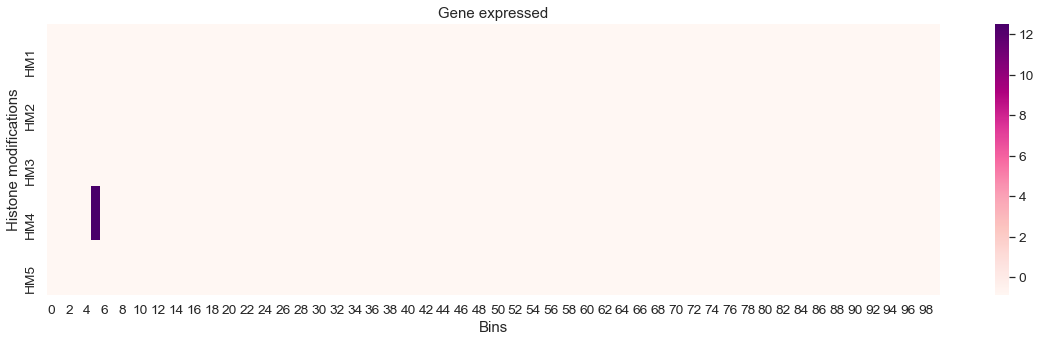

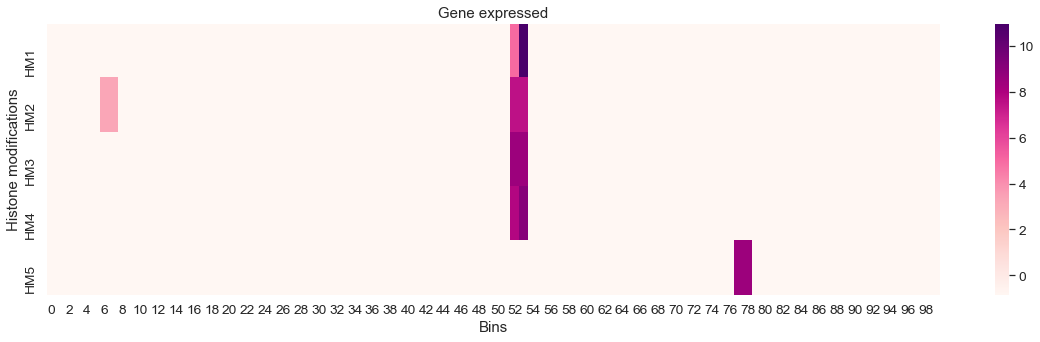

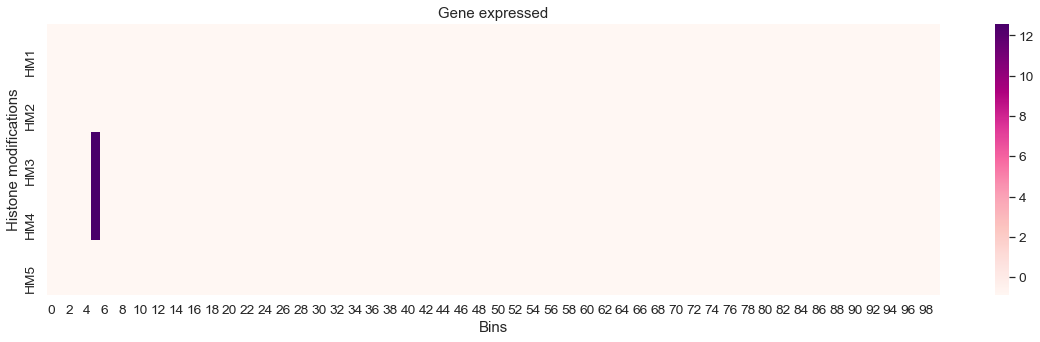

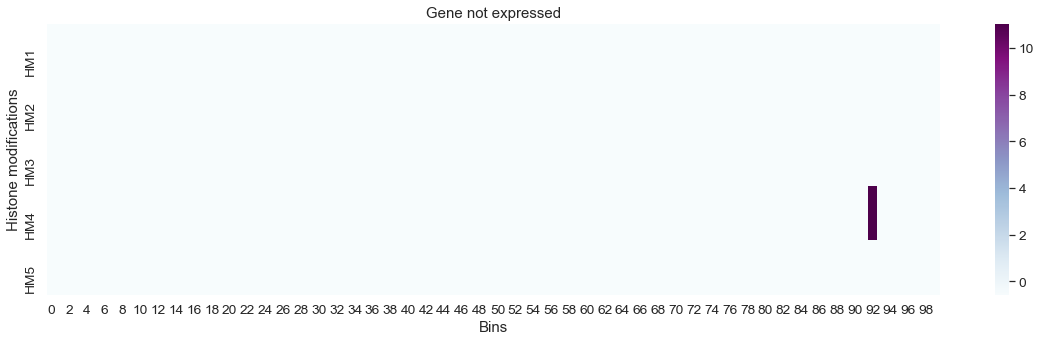

In [57]:
print(f"Worst {show} guesses")
for gene in list(differences.tail(show).index): 
    plot_gene(test_data[gene],test_labels[gene])

Best 5 guesses


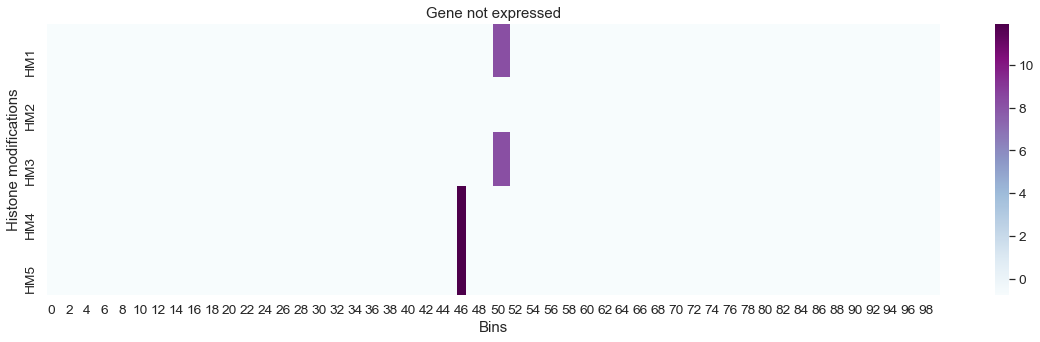

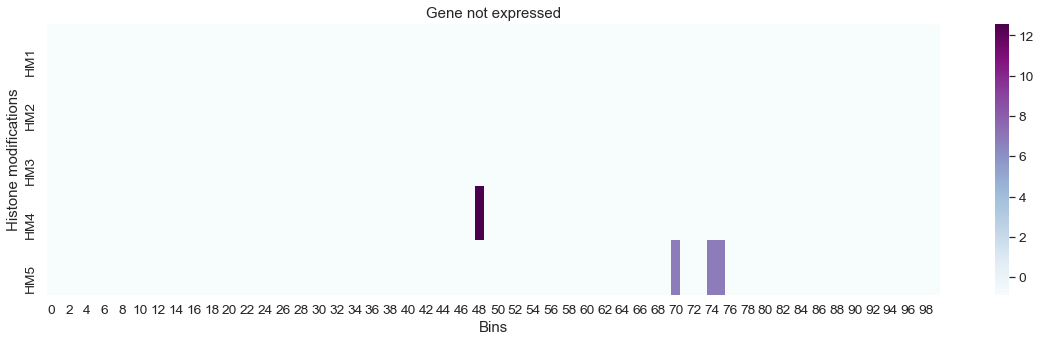

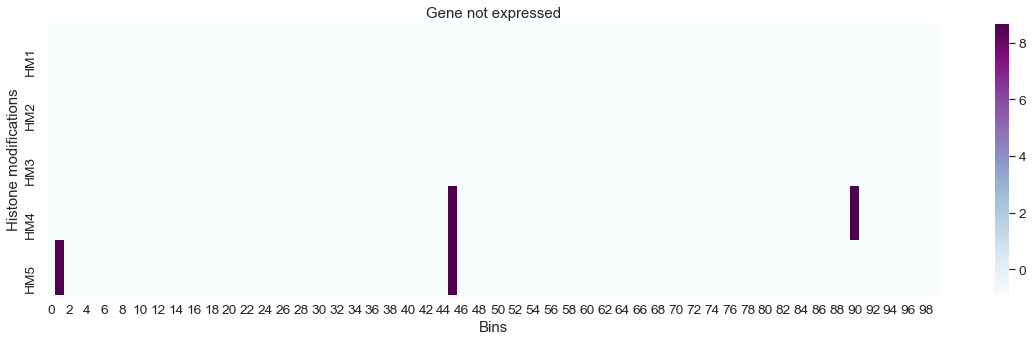

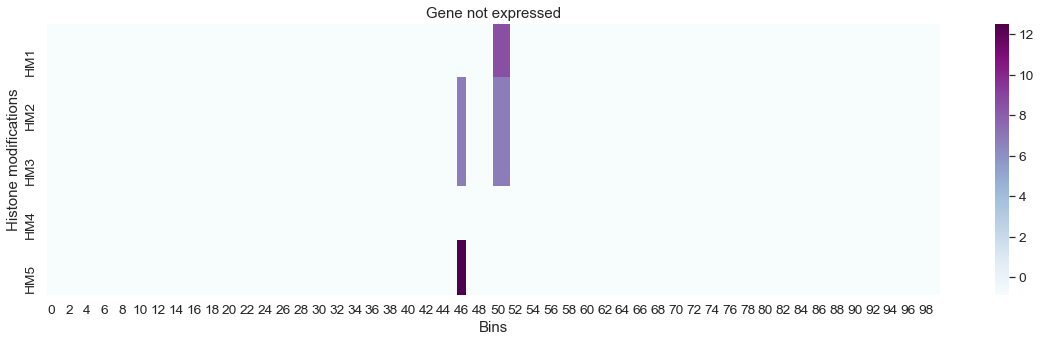

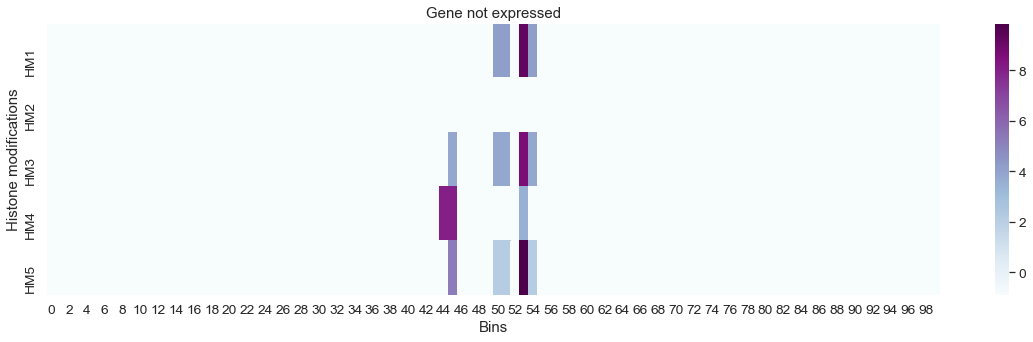

In [56]:
print(f"Best {show} guesses")
for gene in list(differences.head(show).index): 
    plot_gene(test_data[gene],test_labels[gene])